In [1]:

from mpl_toolkits.mplot3d import Axes3D
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
import imageio

from sklearn.cluster import KMeans
from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

In [2]:


# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        #img_3d = imageio.imread(filename)
        img_3d = cv2.imread(filename)
        img_3d = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)
    elif mode == 'L':
        img_3d = imageio.imread(filename, mode = 'L')
    # Downsample the image
    #small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    #blur = cv2.blur(small, (4, 4))

    
    return img_3d


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    #elif mode == 'L':
        #x, y = img_3d.shape
        #img_2d = img_3d.reshape(x*y, 1)
        #img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    # means, labels = kmeans2(img, k)
    Kmean = KMeans(n_clusters=k)
    Kmean.fit(img)

    means = Kmean.cluster_centers_
    labels = Kmean.labels_

    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        pre_cov = randint(low=0, high=2, size=img.shape[0])
        cov = np.array([np.cov(img[pre_cov == i].T) for i in range(k)])
        pis = random(size = k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    # responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)]).T
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)]).T

    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)

    else:
        means, cov, pis = random_init(img, k)
    #print(means, cov, pis)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        #start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        #end_dt = datetime.datetime.now()
        #diff = relativedelta(end_dt, start_dt)
        print("iter: %s" % (cnt))
        print("erro:" + str(abs(likelihood - new_likelihood)))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [3]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdf

In [4]:
FILENAME_LIST = ['/Users/tony/Desktop/498 hwk/hw5/RobertMixed03.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallstrelitzia.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallsunset.jpg']

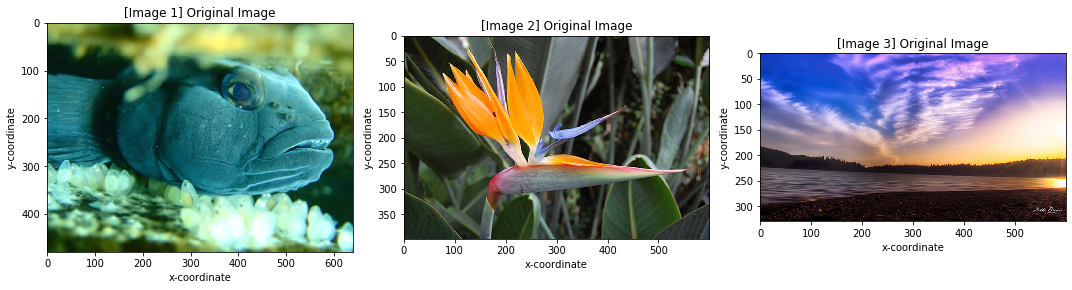

In [5]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
rgb_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    rgb_img = read_img(filename = filename, mode = 'RGB', size = (0.5, 0.5))
    x, y, z = rgb_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y,z))
    # Store img 
    rgb_img_list.append(rgb_img)
    ax.imshow(rgb_img)
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images.pdf')

In [6]:
img_list = [flatten_img(image, mode = 'RGB') for image in rgb_img_list]

In [7]:
len(img_list[2])

198000

In [8]:
# normalize the pixels by dividing them by 255
def normalize(img_list):
    img_list = np.true_divide(img_list, 255)
    return img_list

In [9]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 10, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

iter: 1
erro:4105311.4028797266
log-likelihood = -4105309.4028797266


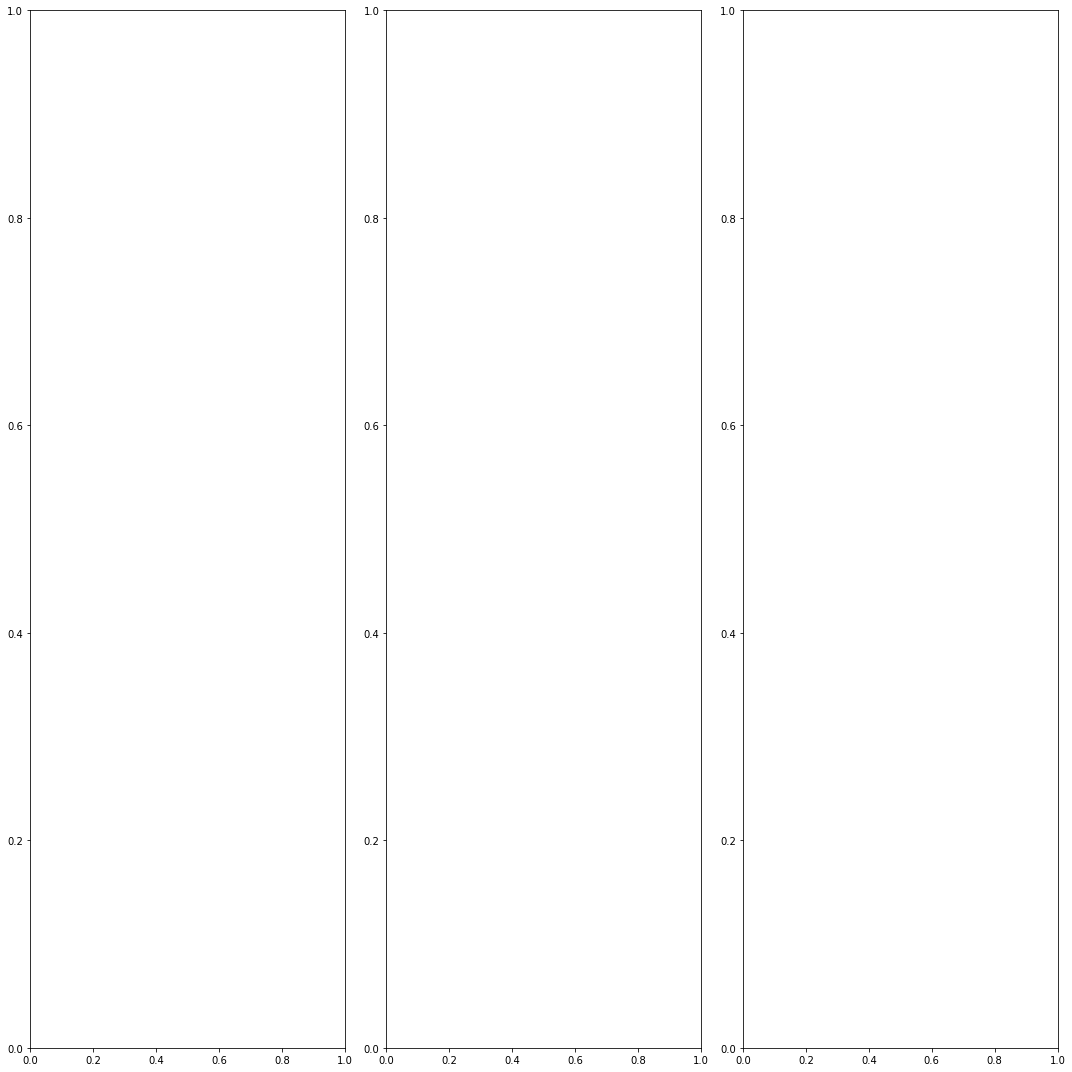

In [20]:
# supposedly the images after replacing kmeans em
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for em_img, ax, dim in zip(em_img_list, ax_list, dim_img_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('em_images.pdf')